In [ ]:
!pip install gensim
!pip uninstall torch torchvision torchaudio -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124


Found existing installation: torch 2.9.1
Uninstalling torch-2.9.1:
  Successfully uninstalled torch-2.9.1
Found existing installation: torchvision 0.24.1+cpu
Uninstalling torchvision-0.24.1+cpu:
  Successfully uninstalled torchvision-0.24.1+cpu
Found existing installation: torchaudio 2.9.1+cpu
Uninstalling torchaudio-2.9.1+cpu:
  Successfully uninstalled torchaudio-2.9.1+cpu


You can safely remove it manually.


Looking in indexes: https://download.pytorch.org/whl/cu124
  Using cached https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp313-cp313-win_amd64.whl.metadata (28 kB)
  Using cached https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp313-cp313-win_amd64.whl.metadata (6.3 kB)
  Using cached https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp313-cp313-win_amd64.whl.metadata (6.8 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
Using cached https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp313-cp313-win_amd64.whl (2532.3 MB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
Using cached https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp313-cp313-win_amd64.whl (6.1 MB)
Using cached https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp313-cp313-win_amd64.whl (4.2 MB)

  Attempting uninstall: sympy

    Found existing installation: sympy 1.14.0

   ---------------------------------------- 0/4

In [ ]:
# IMPORTZZZZZZZZZZZZZZZZ
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support

import gensim.downloader as api

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Μέρος Β: Stacked Bidirectional GRU με Global Max Pooling

Σύγκριση με τους παραδοσιακούς ταξινομητές του Μέρους Α (Naive Bayes, AdaBoost, Logistic Regression) χρησιμοποιώντας ένα Deep Learning μοντέλο.

## Υπερπαράμετροι

In [ ]:
# HYPERPARAMETERS 


DATASET_PATH = "aclImdb"

# Vocabulary & Sequence
MAX_VOCAB_SIZE = 25000
MAX_SEQ_LENGTH = 200

# Model Architecture
EMBEDDING_DIM = 100  # GloVe 100d
HIDDEN_DIM = 128     # GRU hidden size
NUM_LAYERS = 2       # Stacked GRU layers
BIDIRECTIONAL = True
DROPOUT = 0.5
NUM_CLASSES = 2

# Training
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

print("Hyperparameters:")
print(f"  MAX_VOCAB_SIZE: {MAX_VOCAB_SIZE}")
print(f"  MAX_SEQ_LENGTH: {MAX_SEQ_LENGTH}")
print(f"  EMBEDDING_DIM: {EMBEDDING_DIM}")
print(f"  HIDDEN_DIM: {HIDDEN_DIM}")
print(f"  NUM_LAYERS: {NUM_LAYERS}")
print(f"  BIDIRECTIONAL: {BIDIRECTIONAL}")
print(f"  DROPOUT: {DROPOUT}")
print(f"  BATCH_SIZE: {BATCH_SIZE}")
print(f"  LEARNING_RATE: {LEARNING_RATE}")
print(f"  NUM_EPOCHS: {NUM_EPOCHS}")

Hyperparameters:
  MAX_VOCAB_SIZE: 25000
  MAX_SEQ_LENGTH: 200
  EMBEDDING_DIM: 100
  HIDDEN_DIM: 128
  NUM_LAYERS: 2
  BIDIRECTIONAL: True
  DROPOUT: 0.5
  BATCH_SIZE: 64
  LEARNING_RATE: 0.001
  NUM_EPOCHS: 10


## Φόρτωση Δεδομένων

In [ ]:
# LOAD DATA

train_data = load_files(
    os.path.join(DATASET_PATH, "train"),
    categories=["pos", "neg"],
    encoding="utf-8"
)

test_data = load_files(
    os.path.join(DATASET_PATH, "test"),
    categories=["pos", "neg"],
    encoding="utf-8"
)

# Split train into train/dev (development/validation set)
X_train_texts, X_dev_texts, y_train, y_dev = train_test_split(
    train_data.data,
    train_data.target,
    test_size=0.2,
    stratify=train_data.target,
    random_state=42
)

X_test_texts = test_data.data
y_test = test_data.target

print(f"Training samples: {len(X_train_texts)}")
print(f"Development samples: {len(X_dev_texts)}")
print(f"Test samples: {len(X_test_texts)}")

Training samples: 20000
Development samples: 5000
Test samples: 25000


## Προεπεξεργασία Κειμένου & Δημιουργία Λεξιλογίου

In [ ]:
# TEXT PREPROCESSING
def preprocess_text(text):
    """Simple preprocessing: lowercase and tokenize"""
    if isinstance(text, bytes):
        text = text.decode('utf-8', errors='ignore')
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    # Keep only alphanumeric and spaces
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    # Tokenize by whitespace
    tokens = text.split()
    return tokens

# Build vocabulary from training data
def build_vocabulary(texts, max_size=25000):
    """Build vocabulary from training texts"""
    word_counter = Counter()
    for text in texts:
        tokens = preprocess_text(text)
        word_counter.update(tokens)
    
    # Get most common words
    most_common = word_counter.most_common(max_size - 2)  # -2 for PAD and UNK
    
    # Create word to index mapping
    word2idx = {'<PAD>': 0, '<UNK>': 1}
    for idx, (word, count) in enumerate(most_common):
        word2idx[word] = idx + 2
    
    return word2idx

# Build vocabulary
word2idx = build_vocabulary(X_train_texts, MAX_VOCAB_SIZE)
vocab_size = len(word2idx)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 25000


In [ ]:
# ENCODE TEXTS
def encode_text(text, word2idx, max_length):
    """Encode text to sequence of indices with padding/truncation"""
    tokens = preprocess_text(text)
    
    # Convert tokens to indices
    indices = [word2idx.get(token, word2idx['<UNK>']) for token in tokens]
    
    # Pad or truncate
    if len(indices) < max_length:
        indices = indices + [word2idx['<PAD>']] * (max_length - len(indices))
    else:
        indices = indices[:max_length]
    
    return indices

# Encode all datasets
X_train_encoded = [encode_text(text, word2idx, MAX_SEQ_LENGTH) for text in X_train_texts]
X_dev_encoded = [encode_text(text, word2idx, MAX_SEQ_LENGTH) for text in X_dev_texts]
X_test_encoded = [encode_text(text, word2idx, MAX_SEQ_LENGTH) for text in X_test_texts]

# Convert to numpy arrays
X_train_encoded = np.array(X_train_encoded)
X_dev_encoded = np.array(X_dev_encoded)
X_test_encoded = np.array(X_test_encoded)

print(f"Encoded train shape: {X_train_encoded.shape}")
print(f"Encoded dev shape: {X_dev_encoded.shape}")
print(f"Encoded test shape: {X_test_encoded.shape}")

Encoded train shape: (20000, 200)
Encoded dev shape: (5000, 200)
Encoded test shape: (25000, 200)


## Φόρτωση Pre-trained Word Embeddings (GloVe)

In [ ]:
# LOAD GLOVE EMBEDDINGS
print("Loading GloVe embeddings...")
glove_model = api.load("glove-wiki-gigaword-100")
print(f"GloVe embeddings loaded. Vocab size: {len(glove_model)}")

Loading GloVe embeddings...
GloVe embeddings loaded. Vocab size: 400000


In [ ]:
# CREATE EMBEDDING MATRIX
def create_embedding_matrix(word2idx, glove_model, embedding_dim):
    """Create embedding matrix from GloVe"""
    vocab_size = len(word2idx)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    found = 0
    for word, idx in word2idx.items():
        if word in glove_model:
            embedding_matrix[idx] = glove_model[word]
            found += 1
        else:
            # Random initialization for unknown words
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
    
    print(f"Found {found}/{vocab_size} words in GloVe ({100*found/vocab_size:.1f}%)")
    return embedding_matrix

embedding_matrix = create_embedding_matrix(word2idx, glove_model, EMBEDDING_DIM)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Found 24648/25000 words in GloVe (98.6%)
Embedding matrix shape: (25000, 100)


## Dataset & DataLoader

In [ ]:
# PYTORCH DATASET
class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.LongTensor(texts)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Create datasets
train_dataset = IMDBDataset(X_train_encoded, y_train)
dev_dataset = IMDBDataset(X_dev_encoded, y_dev)
test_dataset = IMDBDataset(X_test_encoded, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Dev batches: {len(dev_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 313
Dev batches: 79
Test batches: 391


## Μοντέλο: Stacked Bidirectional GRU με Global Max Pooling

In [ ]:
# MODEL DEFINITION
class BiGRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, 
                 num_classes, embedding_matrix, bidirectional=True, dropout=0.5):
        super(BiGRUClassifier, self).__init__()
        
        # Embedding layer with pre-trained weights
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.FloatTensor(embedding_matrix))
        self.embedding.weight.requires_grad = False  
        
        # Stacked Bidirectional GRU
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Output dimension after GRU
        gru_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        # Fully connected layer
        self.fc = nn.Linear(gru_output_dim, num_classes)
    
    def forward(self, x):
        
        
        # Embedding
        embedded = self.embedding(x)  
        
        # GRU
        gru_out, _ = self.gru(embedded) 
        
        # Global Max Pooling over sequence dimension
        pooled, _ = torch.max(gru_out, dim=1) 
        
        # Dropout
        dropped = self.dropout(pooled)
        
        # Fully connected
        output = self.fc(dropped)  
        
        return output

# Initialize model
model = BiGRUClassifier(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    embedding_matrix=embedding_matrix,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT
).to(device)

print(model)
print(f"\nTotal trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

BiGRUClassifier(
  (embedding): Embedding(25000, 100)
  (gru): GRU(100, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

Total trainable parameters: 473,602


## Εκπαίδευση

In [ ]:
# TRAINING SETUP
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training history
train_losses = []
dev_losses = []
train_accuracies = []
dev_accuracies = []
best_dev_loss = float('inf')
best_epoch = 0

In [ ]:
# TRAINING LOOP
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for texts, labels in loader:
        texts, labels = texts.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return total_loss / len(loader), 100 * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            
            outputs = model(texts)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return total_loss / len(loader), 100 * correct / total

# Train the model
print("Starting training...")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    dev_loss, dev_acc = evaluate(model, dev_loader, criterion, device)
    
    train_losses.append(train_loss)
    dev_losses.append(dev_loss)
    train_accuracies.append(train_acc)
    dev_accuracies.append(dev_acc)
    
    # Save best model
    if dev_loss < best_dev_loss:
        best_dev_loss = dev_loss
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pth')
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Dev Loss: {dev_loss:.4f}, Dev Acc: {dev_acc:.2f}%")
    print()

print("=" * 60)
print(f"Best model saved at epoch {best_epoch} with dev loss: {best_dev_loss:.4f}")

Starting training...
Epoch 1/10:
  Train Loss: 0.5179, Train Acc: 72.83%
  Dev Loss: 0.4286, Dev Acc: 80.50%

Epoch 2/10:
  Train Loss: 0.3803, Train Acc: 83.06%
  Dev Loss: 0.3684, Dev Acc: 83.40%

Epoch 3/10:
  Train Loss: 0.3417, Train Acc: 85.17%
  Dev Loss: 0.3421, Dev Acc: 84.72%

Epoch 4/10:
  Train Loss: 0.3193, Train Acc: 86.55%
  Dev Loss: 0.3405, Dev Acc: 84.90%

Epoch 5/10:
  Train Loss: 0.3023, Train Acc: 87.08%
  Dev Loss: 0.3328, Dev Acc: 85.18%

Epoch 6/10:
  Train Loss: 0.2745, Train Acc: 88.42%
  Dev Loss: 0.3414, Dev Acc: 85.16%

Epoch 7/10:
  Train Loss: 0.2520, Train Acc: 89.75%
  Dev Loss: 0.3443, Dev Acc: 86.10%

Epoch 8/10:
  Train Loss: 0.2223, Train Acc: 91.05%
  Dev Loss: 0.3779, Dev Acc: 84.94%

Epoch 9/10:
  Train Loss: 0.1936, Train Acc: 92.36%
  Dev Loss: 0.3887, Dev Acc: 85.64%

Epoch 10/10:
  Train Loss: 0.1633, Train Acc: 93.64%
  Dev Loss: 0.3936, Dev Acc: 85.36%

Best model saved at epoch 5 with dev loss: 0.3328


## Καμπύλες Εκπαίδευσης

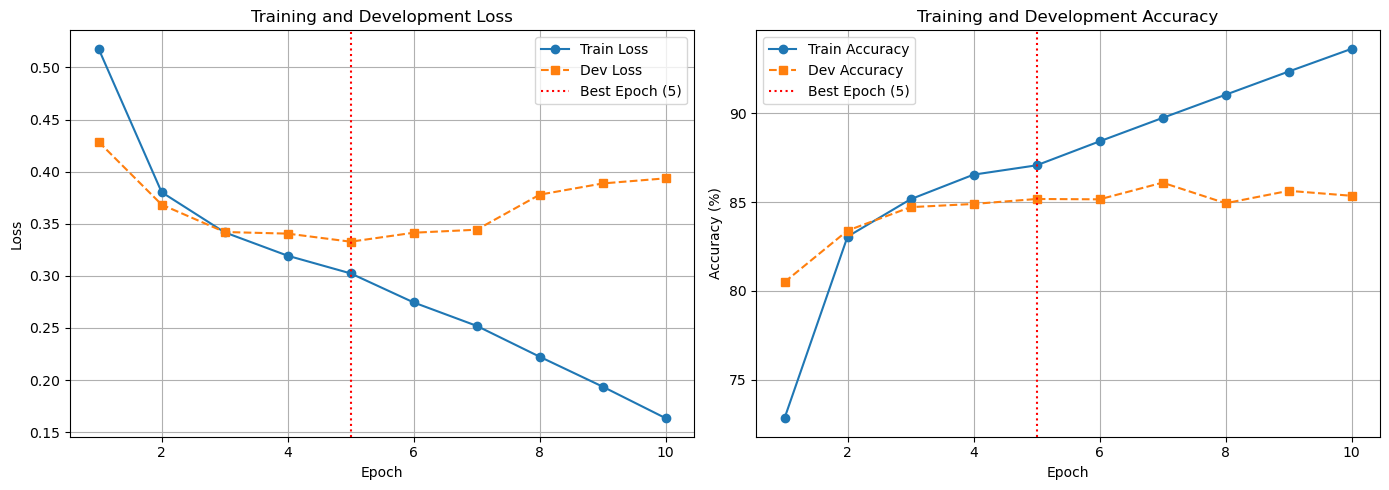

In [ ]:
# PLOT TRAINING CURVES
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(range(1, NUM_EPOCHS + 1), train_losses, 'o-', label='Train Loss')
axes[0].plot(range(1, NUM_EPOCHS + 1), dev_losses, 's--', label='Dev Loss')
axes[0].axvline(x=best_epoch, color='r', linestyle=':', label=f'Best Epoch ({best_epoch})')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Development Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy curves
axes[1].plot(range(1, NUM_EPOCHS + 1), train_accuracies, 'o-', label='Train Accuracy')
axes[1].plot(range(1, NUM_EPOCHS + 1), dev_accuracies, 's--', label='Dev Accuracy')
axes[1].axvline(x=best_epoch, color='r', linestyle=':', label=f'Best Epoch ({best_epoch})')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Development Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Αξιολόγηση στο Test Set

In [ ]:
# LOAD BEST MODEL AND EVALUATE
model.load_state_dict(torch.load('best_model.pth'))

def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for texts, labels in loader:
            texts = texts.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Get predictions on test set
test_preds, test_labels = get_predictions(model, test_loader, device)

In [ ]:
# CLASSIFICATION REPORT
print("=" * 60)
print("STACKED BIDIRECTIONAL GRU with GLOBAL MAX POOLING")
print("=" * 60)
print()
print(classification_report(
    test_labels,
    test_preds,
    target_names=["neg", "pos"],
    digits=3
))

STACKED BIDIRECTIONAL GRU with GLOBAL MAX POOLING

              precision    recall  f1-score   support

         neg      0.902     0.799     0.847     12500
         pos      0.819     0.913     0.863     12500

    accuracy                          0.856     25000
   macro avg      0.860     0.856     0.855     25000
weighted avg      0.860     0.856     0.855     25000



In [ ]:
# DETAILED METRICS

# Per-class metrics
prec_per_class, rec_per_class, f1_per_class, _ = precision_recall_fscore_support(
    test_labels, test_preds, average=None
)

# Micro-averaged
prec_micro, rec_micro, f1_micro, _ = precision_recall_fscore_support(
    test_labels, test_preds, average='micro'
)

# Macro-averaged
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    test_labels, test_preds, average='macro'
)

print("Detailed Metrics:")
print()
print("Per-class:")
print(f"  Negative: Precision={prec_per_class[0]:.3f}, Recall={rec_per_class[0]:.3f}, F1={f1_per_class[0]:.3f}")
print(f"  Positive: Precision={prec_per_class[1]:.3f}, Recall={rec_per_class[1]:.3f}, F1={f1_per_class[1]:.3f}")
print()
print(f"Micro-averaged: Precision={prec_micro:.3f}, Recall={rec_micro:.3f}, F1={f1_micro:.3f}")
print(f"Macro-averaged: Precision={prec_macro:.3f}, Recall={rec_macro:.3f}, F1={f1_macro:.3f}")

Detailed Metrics:

Per-class:
  Negative: Precision=0.902, Recall=0.799, F1=0.847
  Positive: Precision=0.819, Recall=0.913, F1=0.863

Micro-averaged: Precision=0.856, Recall=0.856, F1=0.856
Macro-averaged: Precision=0.860, Recall=0.856, F1=0.855


## Σύγκριση με τους Παραδοσιακούς Ταξινομητές (Μέρος Α)

In [ ]:

# Results from Part A 
results = {
    'Naive Bayes': {'Precision (macro)': 0.843, 'Recall (macro)': 0.841, 'F1 (macro)': 0.841, 'Accuracy': 0.841},
    'Logistic Regression': {'Precision (macro)': 0.865, 'Recall (macro)': 0.865, 'F1 (macro)': 0.865, 'Accuracy': 0.865},
    'AdaBoost': {'Precision (macro)': 0.774, 'Recall (macro)': 0.770, 'F1 (macro)': 0.770, 'Accuracy': 0.770},
    'BiGRU + Global Max Pooling': {'Precision (macro)': prec_macro, 'Recall (macro)': rec_macro, 'F1 (macro)': f1_macro, 'Accuracy': prec_micro}
}

print("Σύγκριση Αποτελεσμάτων:")
print("=" * 80)
print(f"{'Algorithm':<30} {'Precision':<15} {'Recall':<15} {'F1':<15} {'Accuracy':<15}")
print("-" * 80)
for algo, metrics in results.items():
    print(f"{algo:<30} {metrics['Precision (macro)']:<15.3f} {metrics['Recall (macro)']:<15.3f} {metrics['F1 (macro)']:<15.3f} {metrics['Accuracy']:<15.3f}")
print("=" * 80)

Σύγκριση Αποτελεσμάτων:
Algorithm                      Precision       Recall          F1              Accuracy       
--------------------------------------------------------------------------------
Naive Bayes                    0.843           0.841           0.841           0.841          
Logistic Regression            0.865           0.865           0.865           0.865          
AdaBoost                       0.774           0.770           0.770           0.770          
BiGRU + Global Max Pooling     0.860           0.856           0.855           0.856          


## Πίνακας Υπερπαραμέτρων

In [ ]:
# HYPERPARAMETER SUMMARY
print("Υπερπαράμετροι που χρησιμοποιήθηκαν:")
print()
print("| Παράμετρος | Τιμή | Αιτιολόγηση |")
print("|------------|------|-------------|")
print(f"| Embedding Dimension | {EMBEDDING_DIM} | GloVe-100d pre-trained embeddings |")
print(f"| Hidden Dimension | {HIDDEN_DIM} | Επαρκές για sentiment analysis |")
print(f"| Number of GRU Layers | {NUM_LAYERS} | Stacked architecture για καλύτερη αναπαράσταση |")
print(f"| Bidirectional | {BIDIRECTIONAL} | Συλλαμβάνει context και από τις δύο κατευθύνσεις |")
print(f"| Dropout | {DROPOUT} | Regularization για αποφυγή overfitting |")
print(f"| Batch Size | {BATCH_SIZE} | Σύσταση για NLP tasks |")
print(f"| Learning Rate | {LEARNING_RATE} | Default για Adam optimizer |")
print(f"| Max Sequence Length | {MAX_SEQ_LENGTH} | Επαρκές για τα περισσότερα reviews |")
print(f"| Max Vocabulary Size | {MAX_VOCAB_SIZE} | Top λέξεις με βάση συχνότητα |")
print(f"| Optimizer | Adam | Σύσταση της εκφώνησης αντί για SGD |")
print(f"| Pooling | Global Max Pooling | Σύσταση της εκφώνησης |")
print(f"| Best Epoch Selected | {best_epoch} | Βάσει dev loss |")

Υπερπαράμετροι που χρησιμοποιήθηκαν:

| Παράμετρος | Τιμή | Αιτιολόγηση |
|------------|------|-------------|
| Embedding Dimension | 100 | GloVe-100d pre-trained embeddings |
| Hidden Dimension | 128 | Επαρκές για sentiment analysis |
| Number of GRU Layers | 2 | Stacked architecture για καλύτερη αναπαράσταση |
| Bidirectional | True | Συλλαμβάνει context και από τις δύο κατευθύνσεις |
| Dropout | 0.5 | Regularization για αποφυγή overfitting |
| Batch Size | 64 | Σύσταση για NLP tasks |
| Learning Rate | 0.001 | Default για Adam optimizer |
| Max Sequence Length | 200 | Επαρκές για τα περισσότερα reviews |
| Max Vocabulary Size | 25000 | Top λέξεις με βάση συχνότητα |
| Optimizer | Adam | Σύσταση της εκφώνησης αντί για SGD |
| Pooling | Global Max Pooling | Σύσταση της εκφώνησης |
| Best Epoch Selected | 5 | Βάσει dev loss |
